In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
import pandas as pd
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
def initialise(n,erasure_prob):
    """
    Creates a list of erased qubits with the given erasure probability
    :param n: Length of the cubic lattice along one-direction
    :param erasure_prob: erasure probability
    :return EQ: A list of triplets containing locations of erased qubits
    :return k: Number of erased qubits
    """
    k=0
    lattice_points = [(i, j, k) for i in range(n) for j in range(n) for k in range(n)]
    EQ=[]
    for i in range(n*n*n):
        l=random.random()
        if(l<=erasure_prob):
            k=k+1
            EQ.append(lattice_points[i])
    return EQ,k

In [3]:
def initialise_errors(n,EQ,k):    
    """
    Creates two 3D arrays(n X n X n): AZ, AX to represent Z and X errors from the erased qubit
    :param n: Length of the cubic lattice along one-direction
    :param EQ: A list of triplets containing locations of erased qubits
    :param k: Number of erased qubits
    :return AZ: 3D array of Z errors
    :return AX: 3D array of X errors
    """
    EX = np.zeros(k)
    PX = np.zeros(k)
    PY = np.zeros(k)
    EZ = np.zeros(k)
    PZ = np.zeros(k)
    PX = [random.random() for _ in range(k)]
    PY = [random.random() for _ in range(k)]
    PZ = [random.random() for _ in range(k)]
    for i in range (k):
        if (PX[i] <= 0.25):
            EX[i]=EX[i]+1
        if (PY[i] <= 0.25):
            EX[i]=EX[i]+1
            EZ[i]=EZ[i]+1
        if (PZ[i]<= 0.25):
            EZ[i]=EZ[i]+1
        EX[i]=EX[i]%2
        EZ[i]=EZ[i]%2
    AZ = np.zeros((n,n,n))
    AX = np.zeros((n,n,n))
    for i in range(k):
        if EZ[i] == 1.0 :
            AZ[EQ[i][0]][EQ[i][1]][EQ[i][2]]=(AZ[EQ[i][0]][EQ[i][1]][EQ[i][2]]+1)%2
    for i in range(k):
        if EX[i] == 1.0 :
            AX[EQ[i][0]][EQ[i][1]][EQ[i][2]]=(AX[EQ[i][0]][EQ[i][1]][EQ[i][2]]+1)%2
    return AZ,AX

In [4]:
def no_of_err_qubits(n,AZ,AX):
    """Caculates the number of qubits which have been affected by X/Z error
    :param n: Length of the cubic lattice along one-direction
    :param AZ: 3D array of Z errors
    :param AX: 3D array of X errors
    :return c: Number of qubits affected by an error
    """
    c=0
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if AZ[i][j][k] == 1 or AX[i][j][k] == 1:
                    c=c+1
    return c

In [5]:
def creating_Xstabilizers(n):
    """Creates an array of X stabilizers. Each element is a 3D array representing an X stabilizer
    :param n: Length of the cubic lattice along one-direction
    :return SX: Array of X stabilizers of the code
    """
    SX=[]
    L = np.zeros((n,n,n))
    for i in range(n):
        L[0][0][i] = 1
    SX.append(L)
    for i in range(n-1):
        S=np.zeros((n,n,n))
        j = 0
        k = 0
        fl = 0
        direction = 1
        if i%2 == 0:
            S[i][0][0] = 1
            S[i+1][0][0] =1 
            S[i][0][1] = 1
            S[i+1][0][1] = 1
            k = 2
        else :
            S[i][0][0] = 1
            S[i+1][0][0] = 1
            k = 1
        SX.append(S)
        while True:
            S=np.zeros((n,n,n))
            S[i][j][k] = 1
            S[i+1][j][k] = 1
            jump = 0
            if k==0 and direction == -1:
                jump = 1
            if k==n-1 and direction == 1:
                jump = 1
            if jump == 1 and j==n-1:
                SX.append(S)
                fl=1
            if fl == 1:
                break
            if jump == 0:
                k = k + direction
                S[i][j][k] = 1
                S[i+1][j][k] = 1
                SX.append(S)
            if jump == 1:
                direction = -1 * direction
                j=j+1
                S[i][j][k] = 1
                S[i+1][j][k] = 1
                SX.append(S)
            jump = 0
            if k==0 and direction == -1:
                jump = 1
            if k==n-1 and direction == 1:
                jump = 1
            if jump == 1 and j==n-1:
                fl=1
            if fl == 1:
                break
            if jump == 0 :
                k = k + direction
            if jump == 1:
                direction = -1 * direction
                j=j+1
    j=1
    while(True):
        S = np.zeros((n,n,n))
        k = 0
        S[0][j][k] = 1
        S[0][j+1][k] = 1
        SX.append(S)
        k = 1
        while(True):
            S = np.zeros((n,n,n))
            S[0][j][k] = 1
            S[0][j+1][k] = 1
            S[0][j][k+1] = 1
            S[0][j+1][k+1] = 1
            k = k + 2
            SX.append(S)
            if(k == n):
                break
        j = j + 2
        if( j == n ):
            break
    j=0
    while(True):
        S = np.zeros((n,n,n))
        k = n - 1
        S[n-1][j][k] = 1
        S[n-1][j+1][k] = 1
        SX.append(S)
        k = n - 2
        while(True):
            if(k == 1):
                break
            S = np.zeros((n,n,n))
            S[n-1][j][k] = 1
            S[n-1][j+1][k] = 1
            S[n-1][j][k-1] = 1
            S[n-1][j+1][k-1] = 1
            k = k - 2
            SX.append(S)
        j = j + 2
        if( j == n - 1):
            break
    L = np.zeros((n,n,n))
    for i in range(n-1):
        L[n-1][i][0] = 1
        L[n-1][i][1] = 1
    for i in range(n):
        L[n-1][n-1][i] = 1
    SX.append(L)
    return SX

In [6]:
def creating_Zstabilizers(n):
    """Creates an array of Z stabilizers. Each element is a 3D array representing a Z stabilizer
    :param n: Length of the cubic lattice along one-direction
    :return SZ: Array of Z stabilizers of the code
    """
    SZ=[]
    L = np.zeros((n,n,n))
    for k in range(n):
        L[k][0][0] = 1
    SZ.append(L)
    for k in range(n-1):
        S=np.zeros((n,n,n))
        j = 0
        i = 0
        fl = 0
        direction = 1
        if k%2 == 1:
            S[0][0][k] = 1
            S[0][0][k+1] =1 
            S[1][0][k] = 1
            S[1][0][k+1] = 1
            i = 2
        else :
            S[0][0][k] = 1
            S[0][0][k+1] = 1
            i = 1
        SZ.append(S)
        while True:
            S=np.zeros((n,n,n))
            S[i][j][k] = 1
            S[i][j][k+1] = 1
            jump = 0
            if i==0 and direction == -1:
                jump = 1
            if i==n-1 and direction == 1:
                jump = 1
            if jump == 1 and j==n-1:
                SZ.append(S)
                fl=1
            if fl == 1:
                break
            if jump == 0:
                i = i + direction
                S[i][j][k] = 1
                S[i][j][k+1] = 1
                SZ.append(S)
            if jump == 1:
                direction = -1 * direction
                j=j+1
                S[i][j][k] = 1
                S[i][j][k+1] = 1
                SZ.append(S)
            jump = 0
            if i==0 and direction == -1:
                jump = 1
            if i==n-1 and direction == 1:
                jump = 1
            if jump == 1 and j==n-1:
                fl=1
            if fl == 1:
                break
            if jump == 0 :
                i = i + direction
            if jump == 1:
                direction = -1 * direction
                j=j+1
    j=1
    while(True):
        S = np.zeros((n,n,n))
        i = n - 1
        S[i][j][0] = 1
        S[i][j+1][0] = 1
        SZ.append(S)
        i = n - 2
        while(True):
            S = np.zeros((n,n,n))
            S[i][j][0] = 1
            S[i][j+1][0] = 1
            S[i-1][j][0] = 1
            S[i-1][j+1][0] = 1
            i = i - 2
            SZ.append(S)
            if(i == -1):
                break
        j = j + 2
        if( j == n ):
            break
    j=0
    while(True):
        S = np.zeros((n,n,n))
        i = 1
        while(True):
            S = np.zeros((n,n,n))
            S[i][j][n-1] = 1
            S[i][j+1][n-1] = 1
            S[i+1][j][n-1] = 1
            S[i+1][j+1][n-1] = 1
            i = i + 2
            SZ.append(S)
            if(i == n):
                break
        j = j + 2
        if( j == n - 1):
            break
    L = np.zeros((n,n,n))
    for i in range(n-1):
        L[0][i][n-1] = 1
        L[0][i][n-1] = 1
    for i in range(n):
        L[i][n-1][n-1] = 1
    SZ.append(L)
    return SZ
    

In [7]:
def stabilizer_position(n,S):
    """Creates a 3D array of length 2 arrays. Each element stores indices of the 2 stabilizers incident to that qubit
    :param n: Length of the cubic lattice along one-direction
    :param S: Array of X/Z stabilizers
    :return A: 3D array of length 2 arrays containing the 2 stabilizers common to that qubit.
    """
    A = np.zeros((n,n,n,2))
    s=len(S)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                fl = 0
                for l in range(s):
                    for m in range(s):
                        B = S[l] * S[m]
                        if l!=m and B[i][j][k] == 1:
                            A[i][j][k][0] = l
                            A[i][j][k][1] = m
                            fl = 1
                        if fl == 1:
                            break
                    if fl == 1:
                        break
    return A

In [8]:
def stabilizer_meet(n,S):
    """Creates a 2D array of a list of triplets containing all the qubits common to the corresponding 2 stabilizers
    :param n: Length of the cubic lattice along one-direction
    :param S: Array of X/Z stabilizers
    :return SM: 2D array of list of triplets of qubits common to the 2 stabilizers"""
    s = len(S)
    SM = [[[] for _ in range(s)] for _ in range(s)]
    for l in range(s):
        for m in range(s):
            B = S[l] * S[m]
            for i in range(n):
                for j in range(n):
                    for k in range(n):
                        if l!=m and B[i][j][k] == 1:
                            SM[l][m].append((i,j,k))
    return SM

In [9]:
def X_syndromes_results(SX,AZ,s):
    """Creates a 1D array of X syndrome measurement results for the given Z error.
    :param SX: Array of X stabilizers of the code
    :param AZ: 3D array of Z errors
    :param s: Number of X stabiilizers
    :return Syn: 1D array  of X syndrome results. 0 if error commutes with the stabilizer. 1 if error anti commutes.
    """
    Syn = np.zeros(s)
    for i in range(s):
        Syn[i]= (np.sum(AZ*SX[i]))%2
    return Syn

In [10]:
def Z_syndromes_results(SZ,AX,s):
    """Creates a 1D array of Z syndrome measurement results for the given X error.
    :param SZ: Array of Z stabilizers of the code
    :param AX: 3D array of X errors
    :param s: Number of Z stabiilizers
    :return Syn: 1D array  of Z syndrome results. 0 if error commutes with the stabilizer. 1 if error anti commutes.
    """
    Syn = np.zeros(s)
    for i in range(s):
        Syn[i]= (np.sum(AX*SZ[i]))%2
    return Syn

In [11]:
def Erasure_Graph(k,EQ,s,A):
    """Constructs an erasure graph with vertices as stabilizers and edges as erased qubits
    :param k: Number of erased qubits
    :param EQ: A list of triplets containing locations of erased qubits
    :param s: Number of X/Z stabilizers
    :param A: 3D array of length 2 arrays containing the 2 stabilizers common to that qubit
    :return EG: Corresponding erasure graph
    """
    Era_G = np.zeros((s,s))
    for l in range(k):
        p=EQ[l][0]
        q=EQ[l][1]
        r=EQ[l][2]
        i = (int)(A[p][q][r][0])
        j = (int)(A[p][q][r][1])
        Era_G[i][j] = 1
    EG = nx.from_numpy_array(Era_G)
    return EG

In [12]:
def spanning_forest_nx(graph, seeds):
    """
    Constructs a spanning forest including all connected components.
    :param graph: A NetworkX graph (undirected)
    :param seeds: A set of seed vertices
    :return: A NetworkX Graph representing the spanning forest
    """
    forest = nx.Graph()  # Create an empty graph for the spanning forest
    visited = set(seeds)  # Track visited nodes
    queue = list(seeds)   # BFS queue

    # Step 1: Grow trees from given seed vertices
    while queue:
        node = queue.pop(0)  # Dequeue (use pop() for DFS)
        for neighbor in graph.neighbors(node):
            if neighbor not in visited:
                visited.add(neighbor)
                forest.add_edge(node, neighbor)  # Add edge to spanning forest
                queue.append(neighbor)

    # Step 2: Handle unvisited components (nodes not reached from any seed)
    for node in graph.nodes():
        if node not in visited:
            # Start a new BFS tree from the first unvisited node
            visited.add(node)
            queue = [node]
            while queue:
                current = queue.pop(0)
                for neighbor in graph.neighbors(current):
                    if neighbor not in visited:
                        visited.add(neighbor)
                        forest.add_edge(current, neighbor)
                        queue.append(neighbor)
    return forest

In [13]:
def correction_with_boundary(graph,S,k):
    """
    Constructs a correction operator from the spanning forest and non-boundary syndrome results.
    :param graph: Spanning forest
    :param S: Syndrome results
    :param k: Number of stabilizers
    :return list(A): List of edges as correction operator
    """
    A = set()
    # Create a spanning forest (initially, just the graph itself)
    F = nx.Graph(graph)
    while F.number_of_edges() > 0:
        # Find a leaf edge (u, v) where u is a pendant vertex
        leaf_edge = None
        for u in F.nodes():
            if F.degree[u] == 1 and u!=0 and u!=(k-1):  # Pendant vertex
                v = next(iter(F.neighbors(u)))  # Neighbor of u
                leaf_edge = (u, v)
                break
        if leaf_edge is None:
            break
        x, y = leaf_edge
        # Remove the edge from the graph
        F.remove_edge(x, y)
        # Apply the rules
        if S[x] == 1:
            A.add((x, y))  # Add the edge to A
            S[x] = 0
            S[y] = (S[y] + 1) % 2
    return list(A)

In [14]:
def convert_correction_to_matrix(n,result,SM,EQ):
    """Converts the correction operators as a list of edges to a 3D array.
    :param n: Length of the cubic lattice along one-direction
    :param result: List of edges as X/Z correction operator
    :param SM: 2D array of list of triplets of qubits common to the 2 stabilizers
    :param EQ:  A list of triplets containing locations of erased qubits
    :return M: Correction X/Z operator as a 3D array
    """
    length = len(result)
    M = np.zeros((n,n,n))
    for i in range(length):
        a = result[i][0]
        b = result[i][1]
        qubit = (0,0,0)
        setB = set(EQ)
        for triplet in SM[a][b]: 
            if triplet in setB:
                qubit = triplet
                break
        p = (int)(qubit[0])
        q = (int)(qubit[1])
        r = (int)(qubit[2])
        M[p][q][r] = 1
    return M

In [15]:
def zlogical_error_check(n,AZ):
    """Checks if a logical Z error has occured
    :param n: Length of the cubic lattice along one-direction
    :param AZ: 3D array of Z errors
    :return 0/1: 1 if logical Z error has occurred, 0 otherwise
    """
    LX = np.zeros((n,n,n))
    for i in range(n):
        LX[0][0][i] = 1
    slx = np.sum(LX*AZ)%2
    if slx == 1:
        return 1
    else :
        return 0 

In [16]:
def xlogical_error_check(n,AX):
    """Checks if a logical X error has occured
    :param n: Length of the cubic lattice along one-direction
    :param AX: 3D array of X errors
    :return 0/1: 1 if logical X error has occurred, 0 otherwise
    """
    LZ = np.zeros((n,n,n))
    for i in range(n):
        LZ[i][0][0] = 1
    slz = np.sum(LZ*AX)%2
    if slz == 1:
        return 1
    else :
        return 0

In [17]:
def decode(dist,era_prob,samples,X_stab,Z_stab,Xqumeet,Zqumeet,Xstabmeet,Zstabmeet):
    """Runs the simulation a particular number of times for a particular distance to calculate logical error rate.
    :param dist: Distance of the code (has to be odd)
    :param era_prob: Erasure probability
    :param samples: Number of times we need to run the simulation
    :param X_stab: Array of X stabilizers of the code
    :param Z_stab: Array of Z stabilizers of the code
    :param Xqumeet: 3D array of length 2 arrays containing the 2 X stabilizers common to that qubit
    :param Zqumeet:3D array of length 2 arrays containing the 2 Z stabilizers common to that qubit
    :param Xstabmeet: 2D array of list of triplets of qubits common to the 2 X stabilizers
    :param Zstabmeet: 2D array of list of triplets of qubits common to the 2 Z stabilizers
    :return err: Logical error rate
    """
    err = 0 
    # err2 = 0
    # err3 = 0
    for i in trange(samples):
        erased_qubits,leq = initialise(dist,era_prob)
        # t = dist - 1
        # t=t/2
        # flagdist = 0
        Z_error,X_error = initialise_errors(dist,erased_qubits,leq)
        # err_q = no_of_err_qubits(dist,Z_error,X_error)
        # if err_q <= t :
        #     flagdist = 1
        #     err2 = err2 + 1
        no_of_Xstab = len(X_stab)
        X_syndromes = X_syndromes_results(X_stab, Z_error, no_of_Xstab)
        Era_Grp = Erasure_Graph(leq,erased_qubits,no_of_Xstab,Xqumeet)
        seeds = {0,no_of_Xstab-1}
        span_for = spanning_forest_nx(Era_Grp, seeds)
        corr_opt = correction_with_boundary(span_for,X_syndromes,no_of_Xstab)
        corr_matrix = convert_correction_to_matrix(dist,corr_opt,Xstabmeet,erased_qubits)
        Z_error = (Z_error + corr_matrix)%2
        lz=zlogical_error_check(dist,Z_error)
        no_of_Zstab = len(Z_stab)
        Z_syndromes = Z_syndromes_results(Z_stab, X_error, no_of_Zstab)
        Era_Grp = Erasure_Graph(leq,erased_qubits,no_of_Zstab,Zqumeet)
        seeds = {0,no_of_Zstab-1}
        span_for = spanning_forest_nx(Era_Grp, seeds)
        corr_opt = correction_with_boundary(span_for,Z_syndromes,no_of_Zstab)
        corr_matrix = convert_correction_to_matrix(dist,corr_opt,Zstabmeet,erased_qubits)
        X_error = (X_error + corr_matrix)%2
        lx=xlogical_error_check(dist,X_error)
        if lz == 1 or lx == 1:
            err = err + 1
            # if flagdist == 1:
            #     err3 = err3 + 1
    err = err/samples
    return err
    # return err,err2,err3

In [18]:
bins = 7
samples = 10000
erasurep = np.linspace(0.44, 0.52, bins)
dist = 5
X_stab = creating_Xstabilizers(dist)
Z_stab = creating_Zstabilizers(dist)
Xqumeet = stabilizer_position(dist,X_stab)
Zqumeet = stabilizer_position(dist,Z_stab)
Xstabmeet = stabilizer_meet(dist,X_stab)
Zstabmeet = stabilizer_meet(dist,Z_stab)
logical_error_rate_d5 = np.zeros(bins)
halfdisterr_d5 = np.zeros(bins)
fails_d5 = np.zeros(bins)
for i in range(bins):
    # logical_error_rate_d5[i], halfdisterr_d5[i], fails_d5[i] = decode(dist,erasurep[i],samples,X_stab,Z_stab,Xqumeet,Zqumeet,Xstabmeet,Zstabmeet)
    logical_error_rate_d5[i] = decode(dist,erasurep[i],samples,X_stab,Z_stab,Xqumeet,Zqumeet,Xstabmeet,Zstabmeet)
print(logical_error_rate_d5)
# print(halfdisterr_d5)
# print(fails_d5)


100%|██████████| 10000/10000 [00:39<00:00, 255.15it/s]

[0.2221 0.2601 0.2892 0.3257 0.3598 0.3915 0.4305]


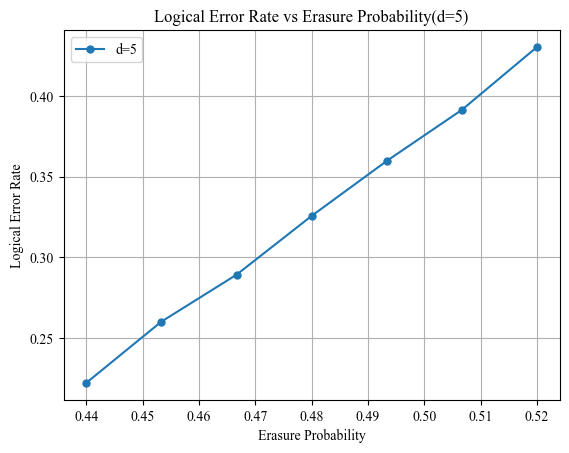

In [19]:
plt.plot(erasurep, logical_error_rate_d5, label='d=5', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability(d=5)')
plt.grid()
plt.show()

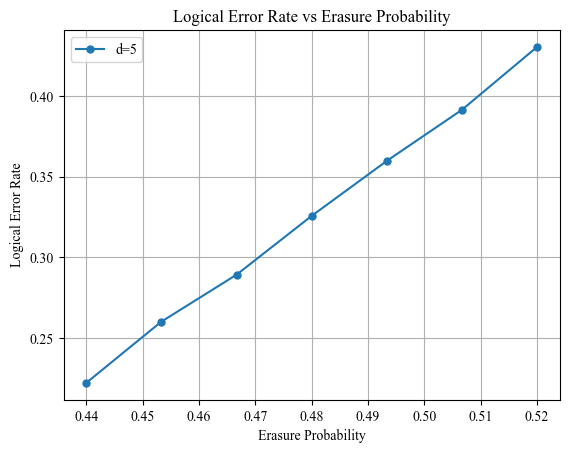

In [20]:
plt.plot(erasurep, logical_error_rate_d5, label='d=5', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
# plt.yscale("log")
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability')

# Display the plot
plt.grid()
plt.show()

In [21]:
bins = 7
samples = 10000
erasurep = np.linspace(0.44, 0.52, bins)
dist = 7
X_stab = creating_Xstabilizers(dist)
Z_stab = creating_Zstabilizers(dist)
Xqumeet = stabilizer_position(dist,X_stab)
Zqumeet = stabilizer_position(dist,Z_stab)
Xstabmeet = stabilizer_meet(dist,X_stab)
Zstabmeet = stabilizer_meet(dist,Z_stab)
logical_error_rate_d7 = np.zeros(bins)
halfdisterr_d7 = np.zeros(bins)
fails_d7 = np.zeros(bins)
for i in range(bins):
    # logical_error_rate_d7[i], halfdisterr_d7[i], fails_d7[i] = decode(dist,erasurep[i],samples,X_stab,Z_stab,Xqumeet,Zqumeet,Xstabmeet,Zstabmeet)
    logical_error_rate_d7[i] = decode(dist,erasurep[i],samples,X_stab,Z_stab,Xqumeet,Zqumeet,Xstabmeet,Zstabmeet)
print(logical_error_rate_d7)
# print(halfdisterr_d7)
# print(fails_d7)

100%|██████████| 10000/10000 [02:47<00:00, 59.73it/s]

[0.1855 0.2265 0.2701 0.3098 0.3554 0.4119 0.4596]


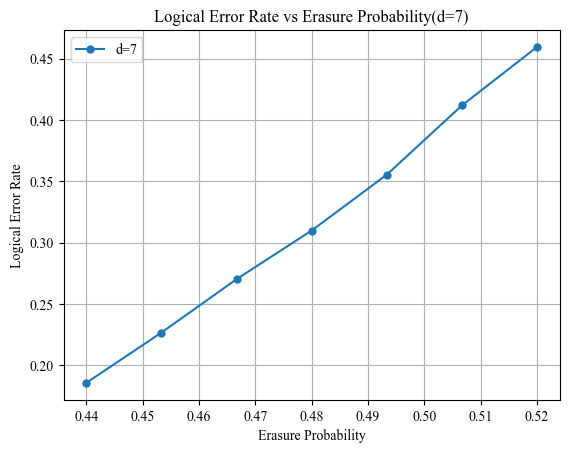

In [22]:
plt.plot(erasurep, logical_error_rate_d7, label='d=7', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability(d=7)')
plt.grid()
plt.show()

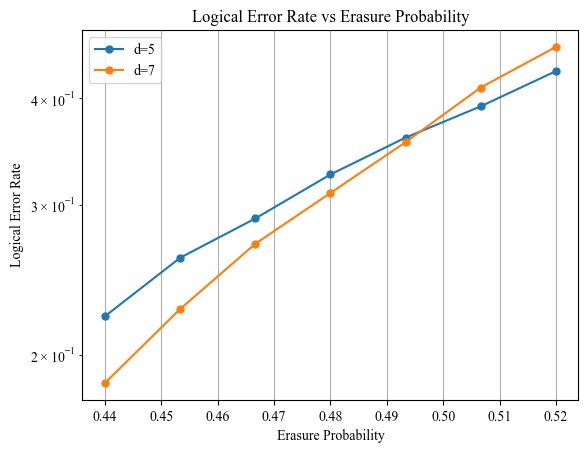

In [23]:
plt.plot(erasurep, logical_error_rate_d5, label='d=5', marker='o', markersize=5)
plt.plot(erasurep, logical_error_rate_d7, label='d=7', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability')
plt.yscale("log")
# Display the plot
plt.grid()
plt.show()

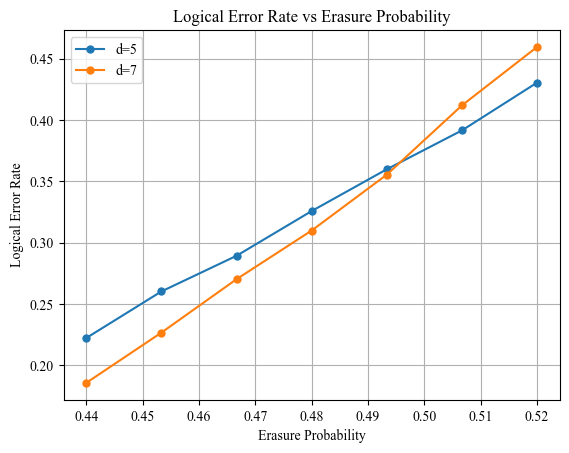

In [24]:
plt.plot(erasurep, logical_error_rate_d5, label='d=5', marker='o', markersize=5)
plt.plot(erasurep, logical_error_rate_d7, label='d=7', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability')
# plt.yscale("log")
# Display the plot
plt.grid()
plt.show()

In [25]:
bins = 7
samples = 10000
erasurep = np.linspace(0.44, 0.52, bins)
dist = 9
X_stab = creating_Xstabilizers(dist)
Z_stab = creating_Zstabilizers(dist)
Xqumeet = stabilizer_position(dist,X_stab)
Zqumeet = stabilizer_position(dist,Z_stab)
Xstabmeet = stabilizer_meet(dist,X_stab)
Zstabmeet = stabilizer_meet(dist,Z_stab)
logical_error_rate_d9 = np.zeros(bins)
halfdisterr_d9 = np.zeros(bins)
fails_d9 = np.zeros(bins)
for i in range(bins):
    # logical_error_rate_d9[i], halfdisterr_d9[i], fails_d9[i] = decode(dist,erasurep[i],samples,X_stab,Z_stab,Xqumeet,Zqumeet,Xstabmeet,Zstabmeet)
    logical_error_rate_d9[i] = decode(dist,erasurep[i],samples,X_stab,Z_stab,Xqumeet,Zqumeet,Xstabmeet,Zstabmeet)
print(logical_error_rate_d9)
# print(halfdisterr_d9)
# print(fails_d9)

100%|██████████| 10000/10000 [11:56<00:00, 13.96it/s]

[0.149  0.1978 0.2493 0.3053 0.3651 0.426  0.4792]


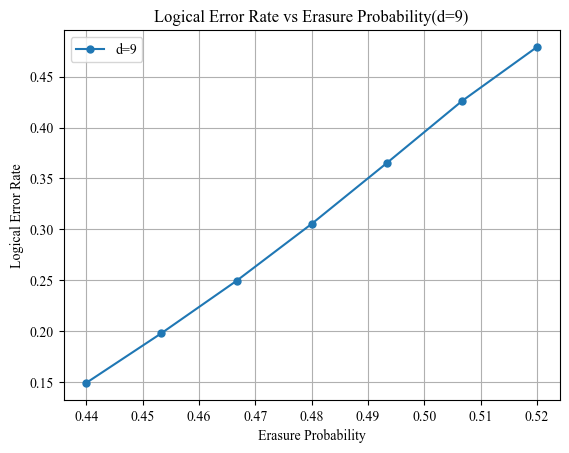

In [26]:
plt.plot(erasurep, logical_error_rate_d9, label='d=9', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability(d=9)')
plt.grid()
plt.show()

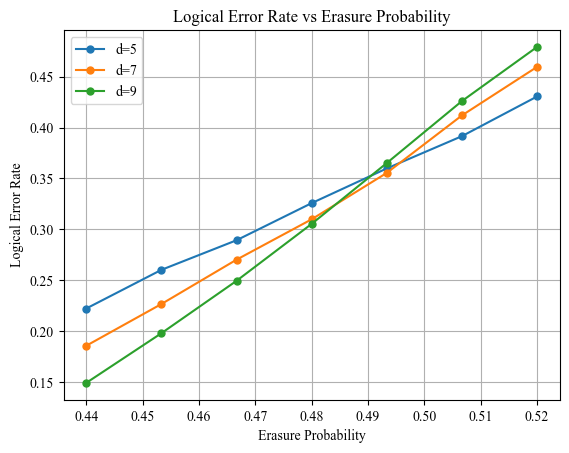

In [27]:
plt.plot(erasurep, logical_error_rate_d5, label='d=5', marker='o', markersize=5)
plt.plot(erasurep, logical_error_rate_d7, label='d=7', marker='o', markersize=5)
plt.plot(erasurep, logical_error_rate_d9, label='d=9', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability')
# plt.yscale("log")
# Display the plot
plt.grid()
plt.show()

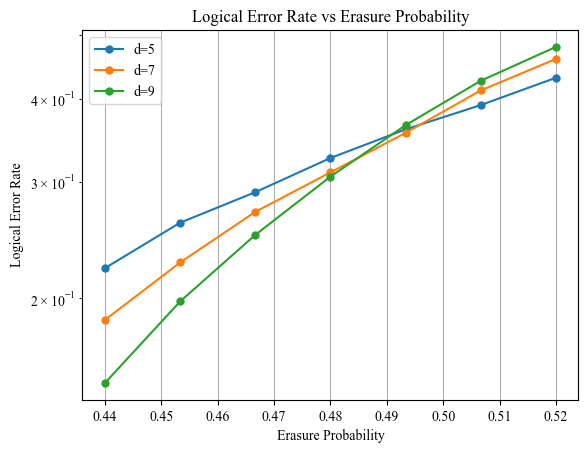

In [28]:
plt.plot(erasurep, logical_error_rate_d5, label='d=5', marker='o', markersize=5)
plt.plot(erasurep, logical_error_rate_d7, label='d=7', marker='o', markersize=5)
plt.plot(erasurep, logical_error_rate_d9, label='d=9', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability')
plt.yscale("log")
# Display the plot
plt.grid()
plt.show()

In [ ]:
bins = 7
samples = 10000
erasurep = np.linspace(0.44, 0.52, bins)
dist = 11
X_stab = creating_Xstabilizers(dist)
Z_stab = creating_Zstabilizers(dist)
Xqumeet = stabilizer_position(dist,X_stab)
Zqumeet = stabilizer_position(dist,Z_stab)
Xstabmeet = stabilizer_meet(dist,X_stab)
Zstabmeet = stabilizer_meet(dist,Z_stab)
logical_error_rate_d11 = np.zeros(bins)
halfdisterr_d11 = np.zeros(bins)
fails_d11 = np.zeros(bins)
for i in range(bins):
    # logical_error_rate_d11[i], halfdisterr_d11[i], fails_d11[i] = decode(dist,erasurep[i],samples,X_stab,Z_stab,Xqumeet,Zqumeet,Xstabmeet,Zstabmeet)
    logical_error_rate_d11[i] = decode(dist,erasurep[i],samples,X_stab,Z_stab,Xqumeet,Zqumeet,Xstabmeet,Zstabmeet)
print(logical_error_rate_d11)
# print(halfdisterr_d11)
# print(fails_d11)

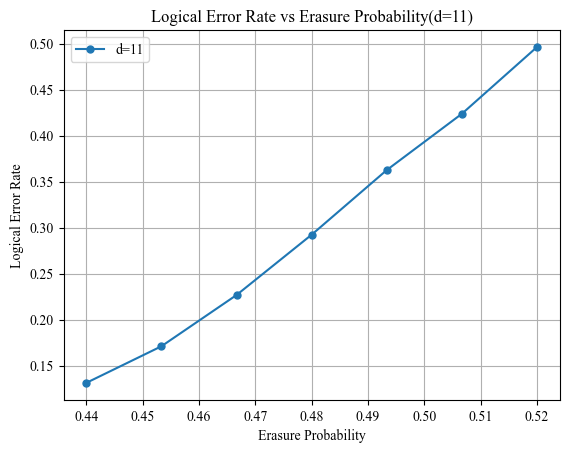

In [ ]:
plt.plot(erasurep, logical_error_rate_d11, label='d=11', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability(d=11)')
plt.grid()
plt.show()

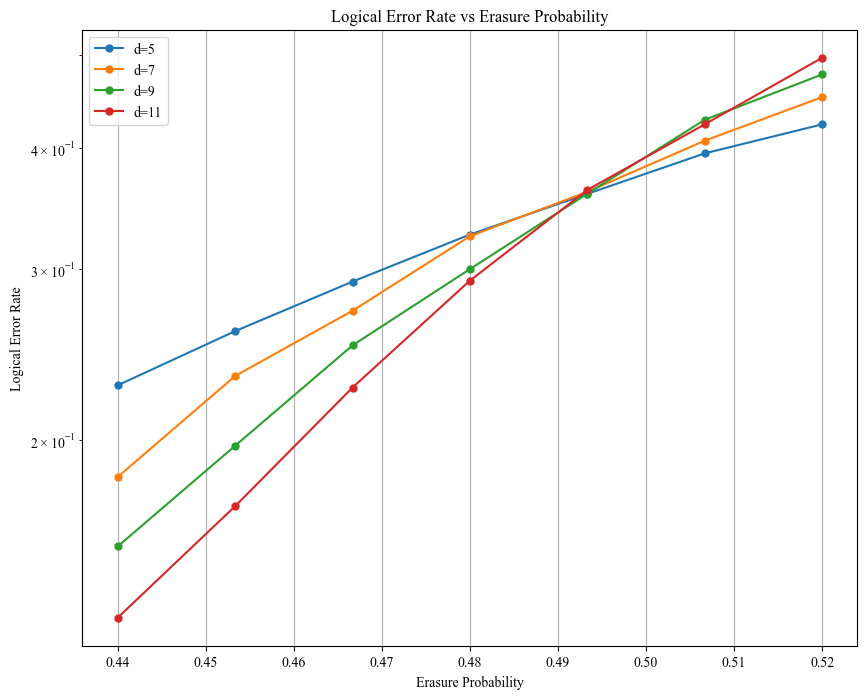

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(erasurep, logical_error_rate_d5, label='d=5', marker='o', markersize=5)
plt.plot(erasurep, logical_error_rate_d7, label='d=7', marker='o', markersize=5)
plt.plot(erasurep, logical_error_rate_d9, label='d=9', marker='o', markersize=5)
plt.plot(erasurep, logical_error_rate_d11, label='d=11', marker='o', markersize=5)
plt.xlabel('Erasure Probability')
plt.ylabel('Logical Error Rate')
plt.legend()
plt.title('Logical Error Rate vs Erasure Probability')
plt.yscale("log")
# Display the plot
plt.grid()
plt.show()

In [ ]:
data = {'Erasure Probability':erasurep, 'Logical Error Rate(d=5)': logical_error_rate_d5}
df = pd.DataFrame(data)
df.to_csv('3D Compass True Full Fixing d=5 data2.csv', index = False)

In [ ]:
data = {'Erasure Probability':erasurep, 'Logical Error Rate(d=7)': logical_error_rate_d7}
df = pd.DataFrame(data)
df.to_csv('3D Compass True Full Fixing d=7 data2.csv', index = False)

In [ ]:
data = {'Erasure Probability':erasurep, 'Logical Error Rate(d=9)': logical_error_rate_d9}
df = pd.DataFrame(data)
df.to_csv('3D Compass True Full Fixing d=9 data2.csv', index = False)

In [ ]:
data = {'Erasure Probability':erasurep, 'Logical Error Rate(d=11)': logical_error_rate_d11}
df = pd.DataFrame(data)
df.to_csv('3D Compass True Full Fixing d=11 data2.csv', index = False)